## Portfolio Exercise: Starbucks
<br>

<img src="https://opj.ca/wp-content/uploads/2018/02/New-Starbucks-Logo-1200x969.jpg" width="200" height="200">
<br>
<br>
 
#### Background Information

The dataset you will be provided in this portfolio exercise was originally used as a take-home assignment provided by Starbucks for their job candidates. The data for this exercise consists of about 120,000 data points split in a 2:1 ratio among training and test files. In the experiment simulated by the data, an advertising promotion was tested to see if it would bring more customers to purchase a specific product priced at $10. Since it costs the company 0.15 to send out each promotion, it would be best to limit that promotion only to those that are most receptive to the promotion. Each data point includes one column indicating whether or not an individual was sent a promotion for the product, and one column indicating whether or not that individual eventually purchased that product. Each individual also has seven additional features associated with them, which are provided abstractly as V1-V7.

#### Optimization Strategy

Your task is to use the training data to understand what patterns in V1-V7 to indicate that a promotion should be provided to a user. Specifically, your goal is to maximize the following metrics:

* **Incremental Response Rate (IRR)** 

IRR depicts how many more customers purchased the product with the promotion, as compared to if they didn't receive the promotion. Mathematically, it's the ratio of the number of purchasers in the promotion group to the total number of customers in the purchasers group (_treatment_) minus the ratio of the number of purchasers in the non-promotional group to the total number of customers in the non-promotional group (_control_).

$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$


* **Net Incremental Revenue (NIR)**

NIR depicts how much is made (or lost) by sending out the promotion. Mathematically, this is 10 times the total number of purchasers that received the promotion minus 0.15 times the number of promotions sent out, minus 10 times the number of purchasers who were not given the promotion.

$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$

For a full description of what Starbucks provides to candidates see the [instructions available here](https://drive.google.com/open?id=18klca9Sef1Rs6q8DW4l7o349r8B70qXM).

Below you can find the training data provided.  Explore the data and different optimization strategies.

#### How To Test Your Strategy?

When you feel like you have an optimization strategy, complete the `promotion_strategy` function to pass to the `test_results` function.  
From past data, we know there are four possible outomes:

Table of actual promotion vs. predicted promotion customers:  

<table>
<tr><th></th><th colspan = '2'>Actual</th></tr>
<tr><th>Predicted</th><th>Yes</th><th>No</th></tr>
<tr><th>Yes</th><td>I</td><td>II</td></tr>
<tr><th>No</th><td>III</td><td>IV</td></tr>
</table>

The metrics are only being compared for the individuals we predict should obtain the promotion – that is, quadrants I and II.  Since the first set of individuals that receive the promotion (in the training set) receive it randomly, we can expect that quadrants I and II will have approximately equivalent participants.  

Comparing quadrant I to II then gives an idea of how well your promotion strategy will work in the future. 

Get started by reading in the data below.  See how each variable or combination of variables along with a promotion influences the chance of purchasing.  When you feel like you have a strategy for who should receive a promotion, test your strategy against the test dataset used in the final `test_results` function.

***

## 1. Loading and exploration of training data

In [34]:
# Load in necessary packages first
from itertools import combinations

from test_results import test_results, score
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
import time

import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

In [2]:
# Load in the training data afterwards
train_data = pd.read_csv('./training.csv')
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044332,-0.385883,1,1,2,2


In [3]:
train_data.shape

(84534, 10)

* Are there duplicated IDs?

In [4]:
train_data.ID.nunique() - train_data.shape[0]

0

* What's the distribution of control vs. treatment group?

In [5]:
train_data.Promotion.value_counts()

Yes    42364
No     42170
Name: Promotion, dtype: int64

* How many cusomer completed a purchases?

In [6]:
train_data.purchase.value_counts()

0    83494
1     1040
Name: purchase, dtype: int64

* How many purchases happened in each group?

In [7]:
treat_purc = train_data.query('Promotion == "Yes" and purchase == 1').shape[0]
cont_purc = train_data.query('Promotion == "No" and purchase == 1').shape[0]

print('Purchases in treatment group: ', treat_purc , '; Purchases in control_group: ', cont_purc)

Purchases in treatment group:  721 ; Purchases in control_group:  319


* Check the score on train data

**Note:** `score` is defined in `test_results.py`: takes in input the data frame and returns the `(irr, nir)` tuple

In [8]:
irr_train, nir_train = score(train_data)

print('irr: {:0.4f}.'.format(irr_train), 'nir: {:0.2f}.'.format(nir_train))

irr: 0.0095. nir: -2334.60.


## 2. Analysis of the Randomization (Invariant Metric)

The first thing we'll check is whether or not there's any indication that the randomization in assigning a participants to the control or treatment group suffered from any issues. In other words, we want to assess that every subject in the population had an equal chance to be assigned either to the control or treatment group. This is our _Invariant_ Metric.

* The **Null Hypothesis** will be that the proportion of members of the control group is the same of the proportion of members of the treatment group $\rightarrow$ the difference in proportions is = 0
* The **Alternative Hypothesis** will be that the proportion of members of the control group is NOT the same of the number of proportion of the treatment group $\rightarrow$ the difference in proportions is $\neq$ 0
* The **Level of Confidence** $\alpha$ will be set = **0.05**

We will execute this test using [bootstrapping](https://en.wikipedia.org/wiki/Bootstrapping_(statistics)). This will allow us to avoid any underlying assumption on the statistics of the original population. 

First of all, let's measure the proportion of people in the control/experimental group, with respect to the total population:

In [9]:
Treat_prop = ((train_data.Promotion == "Yes").sum())/train_data.shape[0]
Cont_prop = (train_data.Promotion == "No").sum()/train_data.shape[0]
prop_diff = Treat_prop - Cont_prop

print('Proportion of people in Control Group: {:0.4f}.'.format(Cont_prop))
print('Proportion of people in Treatment Group: {:0.4f}.'.format(Treat_prop))
print('Difference in Proportions: {:0.4f}.'.format(prop_diff))

Proportion of people in Control Group: 0.4989.
Proportion of people in Treatment Group: 0.5011.
Difference in Proportions: 0.0023.


The difference in proportions that we measured will be the value to compare against the distribution calculated through bootstrapping.

We will consider **10000** samples of **50000** elements extraced _with replacement_ from the training data population. This should provide us enough data for the analysis while being computationally feasible.

In [10]:
differences = []

t0= time.clock()

for _ in range(10000):
    bootsamp = train_data.sample(50000, replace=True)
    Treat_prop = ((bootsamp.Promotion == "Yes").sum())/bootsamp.shape[0]
    Cont_prop = (bootsamp.Promotion == "No").sum()/bootsamp.shape[0]
    differences.append(Treat_prop - Cont_prop)
    
t1 = time.clock() - t0

print('Done. Elapsed time = ', '{:.2f}'.format(t1), ' s')

Done. Elapsed time =  98.34  s


Now we generate a normal distribution with a mean = the mean foreseen by our Null Hypothesis (in this case, **0**), and a standard deviation = the standard deviation of the sample obtained through bootstrapping (in this case `std(differences)`. 

In [11]:
# Display std. deviation
print('Standard Deviation for null distribution = ', '{:.5f}'.format(np.std(differences)))

# Generate distribution
null_dist = np.random.normal(0, np.std(differences), 10000)

Standard Deviation for null distribution =  0.00445


In [ ]:
# Compute the confidence interval bounds
c = .95
lower_limit = np.percentile(null_dist, (1 - c)/2 * 100)
upper_limit = np.percentile(null_dist, (1 + c)/2 * 100)

We can plot a histogram for clarity:

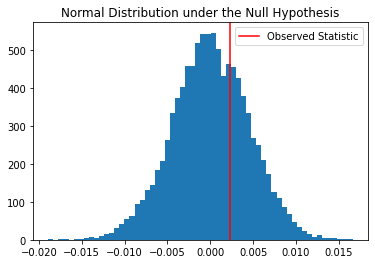

In [12]:
# Plot histogram, showing measured statistics
plt.hist(null_dist, bins=60)
plt.axvline(prop_diff, color='r', label ="Observed Statistic")
plt.legend(loc='upper right')
plt.title("Normal Distribution under the Null Hypothesis");

Finally, we can compare the measured stastics with this population, and evaluate the associated `p-value`. For this kind of testing we're looking at the values that are _more extreme_ that our measure in _either_ direction _away_ from the null hypothesis:

In [18]:
p_val = (null_dist > prop_diff).mean() + (null_dist < - prop_diff).mean()

print('p-value = ', '{:.3f}'.format(p_val))

p-value =  0.613


Given a `p-value` (quite) higher than our confidence level, we **Fail to Reject** the null hypothesis: we can consider the proportion of member in the Control group and Treatment group to be the same, hence can conclude that the randomization process was effective. 

## 3. Analysis of the IRR (Evaluation Metric 1)

Once completed the analysis of the invariant metric we can move on to the actual evaluation metrics defined in the assignement.
Recalling the definition of IRR here:

**Incremental Response Rate (IRR)** 

IRR depicts how many more customers purchased the product with the promotion, as compared to if they didn't receive the promotion. Mathematically, it's the ratio of the number of purchasers in the promotion group to the total number of customers in the purchasers group (_treatment_) minus the ratio of the number of purchasers in the non-promotional group to the total number of customers in the non-promotional group (_control_).

$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$

Looking at this for the training data set can set the folloeing hypothesese:

* The **Null Hypothesis** will be that the IRR $\leq$ 0
* The **Alternative Hypothesis** will be that the IRR $>$ 0
* The **Level of Confidence** $\alpha$ will be set = 0.05/2 = **0.05**

Note that the value of $\alpha$ is defined considering that we have to evaluate 2 different metrics, and applying the Bonferroni's correction.

Also in this case we will leverage [bootstrapping](https://en.wikipedia.org/wiki/Bootstrapping_(statistics)). 

As a remaninder, we have already calculated the total number of purchases in the control and treatment group, as well as the irr on the training data:

In [19]:
print('Purchases in treatment group: ', treat_purc , '; Purchases in control_group: ', cont_purc)
print('irr: {:0.4f}.'.format(irr_train))

Purchases in treatment group:  721 ; Purchases in control_group:  319
irr: 0.0095.


The measured irr will be the value to compare against the distribution calculated through bootstrapping.

Also in this case we will consider **10000** samples of **50000** elements extraced _with replacement_ from the training data population.

In [20]:
IRRs = []

t0= time.clock()

for _ in range(10000):
    bootsample_IRR = train_data.sample(50000, replace=True)
    irr_boot, _ = score(bootsample_IRR)
    IRRs.append(irr_boot)
    
t1 = time.clock() - t0

print('Done. Elapsed time = ', '{:.2f}'.format(t1), ' s')

Done. Elapsed time =  178.99  s


As done previously, we can now generate a normal distribution with a mean = the mean foreseen by our Null Hypothesis (in this case, **0**), and a standard deviation = the standard deviation of the sample obtained through bootstrapping (in this case `std(IRRs)`. 

In [21]:
# Display std. deviation
print('Standard Deviation for null distribution = ', '{:.5f}'.format(np.std(IRRs)))

# Generate distribution
null_dist_IRR = np.random.normal(0, np.std(IRRs), 10000)

Standard Deviation for null distribution =  0.00098


We can plot a histogram for clarity:

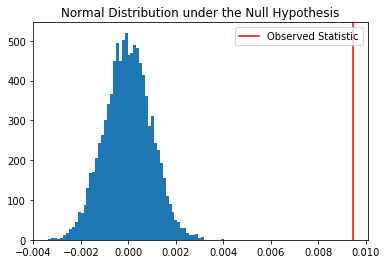

In [22]:
# Plot histogram, showing measured statistics
plt.hist(null_dist_IRR, bins=60)
plt.axvline(irr_train, color='r', label ="Observed Statistic")
plt.legend(loc='upper right')
plt.title("Normal Distribution under the Null Hypothesis");

The plot is fairly clear, but we can anyway compare the measured stastics with this population, and evaluate the associated `p-value`. Given the hypothesis that we are testing, we need to look for values that are _higher_ than the measured statistics under the null hypothesis: 

In [23]:
p_val_IRR = (null_dist_IRR>irr_train).mean()

print('p-value = ', '{:.3f}'.format(p_val_IRR))

p-value =  0.000


Given this `p-value`, we clearly **Reject** the null hypothesis: we can consider the IRR of the Treatment group HIGHER than the IRR of the Control group.

## 4. Analysis of the NIR (Evaluation Metric 2)

Moving on the next metric, the NIR, we recall the definition here also:

**Net Incremental Revenue (NIR)**

NIR depicts how much is made (or lost) by sending out the promotion. Mathematically, this is 10 times the total number of purchasers that received the promotion minus 0.15 times the number of promotions sent out, minus 10 times the number of purchasers who were not given the promotion.

$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$

Similarly to what done previously, for the NIR we define hypotheses as:

* The **Null Hypothesis** will be that the NIR the treatment group is $\leq$ 0
* The **Alternative Hypothesis** will be that the NIR of the treatment group is $>$ 0
* The **Level of Confidence** $\alpha$ will be set = 0.05/2 = **0.05**


Moreover:

* Remember that $\alpha$ is defined applying the Bonferroni's correction.
* The hypotheses will be tested using [bootstrapping](https://en.wikipedia.org/wiki/Bootstrapping_(statistics)). 

We have already calculated the nir on the training data:

In [25]:
print('nir: {:0.4f}.'.format(nir_train))

nir: -2334.6000.


Note the negative value - it would seem that for the training group there was actually an overall _loss_.

The measured nir will be the value to compare against the distribution calculated through bootstrapping.

Also in this case we will consider **10000** samples of **50000** elements extraced _with replacement_ from the training data population.

In [26]:
NIRs = []

t0= time.clock()

for _ in range(10000):
    bootsample_NIR = train_data.sample(50000, replace=True)
    _ , nir_boot = score(bootsample_NIR)
    NIRs.append(nir_boot)
    
t1 = time.clock() - t0

print('Done. Elapsed time = ', '{:.2f}'.format(t1), ' s')

Done. Elapsed time =  199.46  s


Once again, we can now generate a normal distribution with a mean = the mean foreseen by our Null Hypothesis (in this case, **0**), and a standard deviation = the standard deviation of the sample obtained through bootstrapping (in this case `std(NIRs)`. 

In [27]:
# Display std. deviation
print('Standard Deviation for null distribution = ', '{:.5f}'.format(np.std(NIRs)))

# Generate distribution
null_dist_NIR = np.random.normal(0, np.std(NIRs), 10000)

Standard Deviation for null distribution =  246.68003


We can plot a histogram:

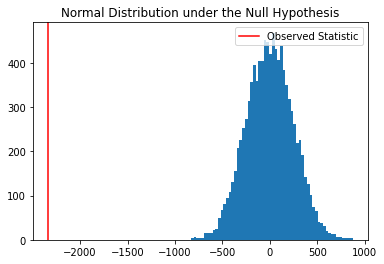

In [28]:
# Plot histogram, showing measured statistics
plt.hist(null_dist_NIR, bins=60)
plt.axvline(nir_train, color='r', label ="Observed Statistic")
plt.legend(loc='upper right')
plt.title("Normal Distribution under the Null Hypothesis");

Here too the plot is quite clear; we calculate a `p-value` again looking for values that are _higher_ than the measured statistics under the null hypothesis: 

In [29]:
p_val_NIR = (null_dist_NIR>nir_train).mean()

print('p-value = ', '{:.3f}'.format(p_val_NIR))

p-value =  1.000


Given this `p-value`, we obviously **Fail to Reject** the null hypothesis: we can consider the NIR of the Treatment group LOWER than the NIR of the Control group.

## 5. Training of a Prediction Model

Once assessed the data and what effect the campaign had on the partecipants, we can try to set up a prediction model that would evluate the 7 characteristics of every partecipant to assess whether or not he/she would actually make a purchase after having received the promotion.

In [30]:
# Copying the dataframe over 
data_exp = train_data.copy()

In [31]:
# Only considering the experiment group for our model training 
data_exp = data_exp[data_exp['Promotion']=="Yes"]

In [32]:
# Dropping the irrelavant columns 
data_exp.drop(['ID','Promotion'], axis = 1, inplace=True)

In [33]:
# Splitting our data into predictors and target variables
X = data_exp.drop(['purchase'],axis=1)
y = data_exp.purchase

In [35]:
# Scaling our inputs 
min_max_scaler = preprocessing.MinMaxScaler()
X = min_max_scaler.fit_transform(X)

In [36]:
# Instantiating our model and fitting it
clf = RandomForestClassifier(n_estimators=100)

t0= time.clock()

clf.fit(X,y)

t1 = time.clock() - t0

print('Done. Elapsed time = ', '{:.2f}'.format(t1), ' s')

Done. Elapsed time =  2.13  s


In [ ]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    
    
    
    
    return promotion

In [ ]:
# This will test your results, and provide you back some information 
# on how well your promotion_strategy will work in practice

test_results(promotion_strategy)